## CS441: Applied ML - HW 3

## Part 1: Spam Detection with Naive Bayes Classifier

We want to classify text messages as “spam” (unwanted) or “ham” (genuine). We will use data (spam.csv) from the Kaggle SMS spam dataset. We’ve provided the loading and pre-processing code to generate:
* `unique_words`: the unique set of words in the dataset
* `(x_train, y_train, msg_train)`: counts of words in each message, spam (y=1) or not spam (y=-1) labels, and the message string for each training sample; `x_train[n][j]` is the count of the `j`th word in the `n`th sample.
* `*_val` and `*_test`, similar to above, for the val and test splits
We will use a Naive Bayes Classifier.

See assignment for details (equations are not easy to reproduce here).

In [1]:
import csv
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

from google.colab import drive
drive.mount('/content/drive')
datadir = "/content/drive/My Drive/CS441/24FA/hw3/" # choose proper location

# don't change the code below

# read data
with open(datadir + 'spam.csv', encoding='latin-1') as csvfile:
    datareader = csv.reader(csvfile, delimiter=',')
    y = np.zeros((10000,))
    X = []
    n = 0
    rownum = 0
    for row in datareader:
      if rownum == 0:
        rownum += 1
        continue
      rownum += 1
      if row[0]=='ham':
        y[n] = -1
      else:
        y[n] = 1
      X.append(row[1])
      n += 1
y= y[:n]

# y[n] = -1 for ham, 1 for spam
print(y[0])
print(X[0])

# parse the text messages into words and count the words in each row
vectorizer = CountVectorizer(analyzer='word')
word_count = vectorizer.fit_transform(X).toarray()

print(f"We have {word_count.shape[0]} examples with {word_count.shape[1]} unique words.")
unique_words = vectorizer.get_feature_names_out()

# split data into train (50%), validation (25%), and test (25%)
x_train = word_count[::2]
y_train = y[::2]
msg_train = X[::2]
x_val = word_count[1::4]
y_val = y[1::4]
msg_val = X[1::4]
x_test = word_count[3::4]
y_test = y[3::4]
msg_test = X[3::4]


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
-1.0
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
We have 5572 examples with 8672 unique words.


#### 1. Train your Naive Bayes Classifier
I.e. P(y), P(w|y)) using the train set with =1 and compute the accuracy on the val set.  You should get P(y=1)=0.142, P(call|spam) = 0.0104, and P(call|ham)=0.0029. Your validation accuracy should be higher than 95%.

In [2]:
# TO DO

# Compute the priors spam and ham
Prob_spam = np.mean(y_train == 1)
Prob_ham = np.mean(y_train == -1)

print("You should get")
print(f"P(y=1)={Prob_spam:.3f},")

''' Check if spam + ham == 1 '''
# print(f"P(y=-1)={Prob_ham:.3f},")
# print(f"1 == {Prob_ham + Prob_spam:.3f}")

# Get sums and laplace for likelihood calculations
alpha = 1  # 1 is default value for laplace
num_spam_words = np.sum(x_train[y_train == 1], axis=0)
num_ham_words = np.sum(x_train[y_train == -1], axis=0)
total_words_spam = np.sum(num_spam_words)
total_words_ham = np.sum(num_ham_words)

# Compute the likelihoods using Laplace smoothing
P_word_given_spam = (num_spam_words + alpha) / (total_words_spam + alpha * len(unique_words)) # Laplace to not break calculation when total words = 0
P_word_given_ham = (num_ham_words + alpha) / (total_words_ham + alpha * len(unique_words))

# Find givens for the word call
word_idx = np.where(unique_words == 'call')[0]
print(f"P(call|spam) = {P_word_given_spam[word_idx[0]]:.4f}, and")
print(f"P(call|ham) = {P_word_given_ham[word_idx[0]]:.4f}")

# Predict and calculate accuracy in the validation set
log_spam_prob = np.log(Prob_spam) + x_val.dot(np.log(P_word_given_spam)) # Log to prevent underflow
log_ham_prob = np.log(Prob_ham) + x_val.dot(np.log(P_word_given_ham))
spam_scores = log_spam_prob - log_ham_prob
y_val_pred = np.where(spam_scores > 0, 1, -1)

# Check if validation accuracy is > 95%
print("Your validation accuracy should be higher than 95%")
accuracy = np.mean(y_val_pred == y_val)
print(f"Validation Accuracy: {accuracy:.2%}")


You should get
P(y=1)=0.142,
P(call|spam) = 0.0104, and
P(call|ham) = 0.0029
Your validation accuracy should be higher than 95%
Validation Accuracy: 98.13%


#### 2. Data exploration
What are the 10 spammiest words (i.e. words with highest  logP(wj|spam)- logP(wj|ham))?  What are the 10 hammiest words? Which val message is the spammiest ham (message with highest spam score but y=-1)? Which is hammiest spam (message with lowest spam score but y=1)?  Spammiest spam? Hammiest ham?

In [3]:
# TO DO

# Compute the difference in log-probabilities
log_diff = np.log(P_word_given_spam) - np.log(P_word_given_ham)

# 10 spammiest words, the 10 hammiest words
spammiest_words = unique_words[np.argsort(log_diff)[-10:]]
hammiest_words = unique_words[np.argsort(log_diff)[:10]]
print("Spammiest Words:", spammiest_words)
print("Hammiest Words:", hammiest_words)

# The spammiest ham
ham_messages = np.array(msg_val)[y_val == -1] # Get booleans of each word's spamness
spammiest_ham_index = np.argmax(spam_scores[y_val == -1])  # Get the index with the most spam score  but label is 'ham'
spammiest_ham_msg = ham_messages[spammiest_ham_index]  # Get the ham msg using the index given
print(f"The Spammiest Ham: {spammiest_ham_msg}")

# The hammiest spam
spam_messages = np.array(msg_val)[y_val == 1] # Get booleans of each word's spamness
hammiest_spam_index = np.argmin(spam_scores[y_val == 1])  # Get the index with the least spam score but label is 'spam'
hammiest_spam_msg = spam_messages[hammiest_spam_index]  # Get the spam msg using the index given
print(f"Hammiest Spam: {hammiest_spam_msg}")

# The spammiest spam
spammiest_spam_index = np.argmax(spam_scores[y_val == 1]) # same as hammiest spam but get argmax
spammiest_spam_msg = spam_messages[spammiest_spam_index]

# The hammiest ham
hammiest_ham_index = np.argmin(spam_scores[y_val == -1]) # same as spammiest ham but get argmin
hammiest_ham_msg = ham_messages[hammiest_ham_index]

print(f"Spammiest Spam: {spammiest_spam_msg}")
print(f"Hammiest Ham: {hammiest_ham_msg}")


Spammiest Words: ['18' 'cs' '16' '500' 'tone' 'www' '150p' 'uk' 'prize' 'claim']
Hammiest Words: ['gt' 'lt' 'he' 'but' 'lor' 'da' 'she' 'later' 'ì_' 'wat']
The Spammiest Ham: Waqt se pehle or naseeb se zyada kisi ko kuch nahi milta,Zindgi wo nahi he jo hum sochte hai Zindgi wo hai jo ham jeetey hai..........
Hammiest Spam: LIFE has never been this much fun and great until you came in. You made it truly special for me. I won't forget you! enjoy @ one gbp/sms
Spammiest Spam: FREE for 1st week! No1 Nokia tone 4 ur mob every week just txt NOKIA to 8007 Get txting and tell ur mates www.getzed.co.uk POBox 36504 W45WQ norm150p/tone 16+
Hammiest Ham: Sad story of a Man - Last week was my b'day. My Wife did'nt wish me. My Parents forgot n so did my Kids . I went to work. Even my Colleagues did not wish. As I entered my cabin my PA said, '' Happy B'day Boss !!''. I felt special. She askd me 4 lunch. After lunch she invited me to her apartment. We went there. She said,'' do u mind if I go into th

#### 3. Precision-recall trade-off
You want to flag spam messages with minimal false positives. Using the val set, compute precision/recall and display the PR curve. Programmatically, find the threshold with highest recall, where precision > 0.99.  Report the accuracy, precision, and recall on the test set using the same model and the selected threshold.

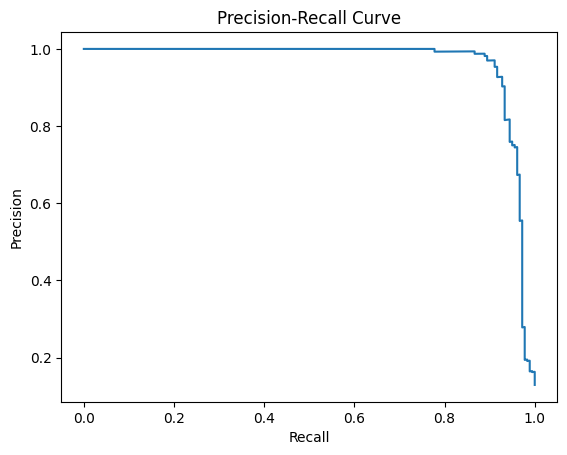

Best Threshold: 6.095247027449673, Precision at threshold: 0.994, Recall at threshold: 0.867
Test Set with best threshold Accuracy: 0.976, Precision: 1.000, Recall: 0.808


In [4]:
import matplotlib.pyplot as plt
# https://stackoverflow.com/questions/31421413/how-to-compute-precision-recall-accuracy-and-f1-score-for-the-multiclass-case
from sklearn.metrics import precision_recall_curve, accuracy_score, precision_score, recall_score


# TO DO

# Use the provided p_r_curve function to get needed variables for graph
precision, recall, thresholds = precision_recall_curve(y_val, spam_scores)

plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

# Find threshold with highest recall given precision > 0.99
sorted_indices = np.argsort(recall[:-1])[::-1]  # Sort recall (invert to get highest to lowest)

best_threshold = None
best_recall = 0

for idx in sorted_indices: # Used argsort to get indices of matching precision
    if precision[idx] > 0.99:
        best_recall = recall[idx]
        best_threshold = thresholds[idx]
        break  # The first threshold will be the best

print(f"Best Threshold: {best_threshold}, Precision at threshold: {precision[idx]:.3f}, Recall at threshold: {best_recall:.3f}")

# Use best threshold on test set
spam_scores_test = np.log(Prob_spam) + x_test.dot(np.log(P_word_given_spam))
ham_scores_test = np.log(Prob_ham) + x_test.dot(np.log(P_word_given_ham))
test_spam_scores = spam_scores_test - ham_scores_test

# Use where to predict
y_test_pred = np.where(test_spam_scores > best_threshold, 1, -1)

# Get a, p, and r on the test set
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)

print(f"Test Set with best threshold Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}")

## Part 2: Robust Estimation

The corrupted salary dataset has three variables: salary, years, school.  Salary is the reported salary of each person.  Years is the number of years of experience in the job.  School is the university where the person last had a degree. For the core assignment, we’ll only use salary, and the stretch goals will use the other two variables. Some of the reported salary information is wrong (some incorrect value is provided), so we want to learn things from the data in a way that is robust to the wrong data. We refer to correctly entered data as “valid”.

Estimate the true mean, standard deviation, min, and max of the salaries using three different methods.

In [5]:
import numpy as np
from matplotlib import pyplot as plt
from google.colab import drive

drive.mount('/content/drive')
datadir = "/content/drive/My Drive/CS441/24FA/hw3/"

# load data
T = np.load(datadir + 'salary.npz')
(salary, years, school) = (T['salary'], T['years'], T['school'])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### 1. Assume no noise
Compute the statistics for the data as a whole

In [6]:
# TO DO

# Pretty straightforward
salary_mu = np.mean(salary)
salary_std = np.std(salary)
salary_min = np.min(salary)
salary_max = np.max(salary)

print('Mean: {}  Std: {}  Min: {}   Max: {}'.format(salary_mu, salary_std, salary_min, salary_max))

Mean: 123749.835  Std: 61953.77348723623  Min: 64694.0   Max: 611494.0


#### 2. Percentiles
Assume valid data will fall between the 5th and 95th percentile. Adjust estimates of the min and max by assuming that the valid data has a uniform distribution (see lecture on robust fitting).

In [7]:
pct = 0.05

# TO DO

# https://stackoverflow.com/questions/2374640/how-do-i-calculate-percentiles-with-python-numpy
# https://www.geeksforgeeks.org/numpy-percentile-in-python/

pct_x_5 = np.percentile(salary, 5)
pct_x_95 = np.percentile(salary, 95)

# Apply robust fitting
salary_min = pct_x_5 - (pct_x_95 - pct_x_5) * (pct / (1 - 2 * pct))
salary_max = pct_x_95 + (pct_x_95 - pct_x_5) * (pct / (1 - 2 * pct))

# Get rid of data in lower 5 percentile and higher 95 percentile
filtered_salary = np.array([])
for sal in salary:
  if sal > pct_x_5 and sal < pct_x_95:
    filtered_salary = np.append(filtered_salary, sal)

# Now do the same as before
salary_mu = np.mean(filtered_salary)
salary_std = np.std(filtered_salary)

print('Mean: {}  Std: {}  Min: {}   Max: {}'.format(salary_mu, salary_std, salary_min, salary_max))

Mean: 113878.65  Std: 15876.450453939286  Min: 75493.8   Max: 159900.79999999973


#### 3. EM
Assume valid data follows a Gaussian distribution, while the fake data has a uniform distribution between the minimum and maximum value of salary. For mean and std, report the estimated mean and std of the valid salary distribution. For min and max, report the min and max salaries that have greater than 50% chance of being valid. Also report the estimated probability that a random sample is valid, and the first five indices of salaries that are not likely to be valid.

In [8]:

# TO DO

# Take example from EM - Annotator Problem,
# but revise to have M (Num of Annotators) be 1 since each datapoint is 1 teacher
# and we do not know the true salary (Which is when we should be using EM Algo)

# We can not plot because the true salary is unknown
# def plot_est(true_salaries, est_salaries):
#   est_salaries = est_salaries.flatten()
#   msq = 0
#   for i in range(len(true_salaries)):
#     msq += (true_salaries[i]-est_salaries[i])**2
#     plt.plot(i, true_salaries[i], 'g.')
#     plt.plot(i, est_salaries[i], 'r*')
#     plt.plot([i, i], [true_salaries[i], est_salaries[i]], 'r')
#   plt.show()
#   print('RMS Err: {:0.3f}'.format(np.sqrt(msq/len(true_salaries))))

print("Salary shape:", salary.shape)


# Initialize parameters
niter = 20
N = salary.shape[0]
M = 1 # N is 1-dimensional

# Initialize by assuming that all salaries are good
salary_mean = salary.mean()  # mu_i
salary_std = np.sqrt(np.sum((salary - salary_mean) ** 2, axis=None) / N / M)  # sigma
pz = 0.5  # P(z=1) = 0.5 initially

# Plot initial estimate // No plotting because we do not know true data
# true_salary = 10 * (np.sin(np.arange(N) / N * 2 * np.pi) + 1.2) / 2.4
# plot_est(true_salary, np.full_like(true_salary, salary_mean))  # Plot constant mean

for t in range(niter):

  last_mean = salary_mean.copy()

  # E-step
  # update probability that each annotator is good
  p_valid_given_s = np.zeros((N,1))  # w_a = P(z_a=1 | salarys, theta_t)

  for i in range(N):
    p_s_good = pz * (1 / (np.sqrt(2 * np.pi) * salary_std)) * np.exp(-0.5 * ((salary[i] - salary_mean) / salary_std) ** 2)
    p_s_bad = (1 - pz) * (1 / (salary.max() - salary.min()))  # Uniform probability for invalid data
    p_valid_given_s[i] = p_s_good / (p_s_good + p_s_bad)
  print('\niter {}'.format(t))
  print(np.round(p_valid_given_s.transpose()*1000)/1000)

  # M-step
  # assign parameters that maximize likelihood under latent variable likelihoods

  # estimate mean
  w_salary_sum = 0
  for i in range(N): # Do not need to double loop since N is 1-D
    w_salary_sum += salary[i] * p_valid_given_s[i]
  salary_mean = w_salary_sum / np.sum(p_valid_given_s)

  # estimate std
  w_sqdiff_sum = 0
  for i in range(N): # Do not need to double loop since N is 1-D
    w_sqdiff_sum += p_valid_given_s[i]*(salary[i] - salary_mean)**2
  salary_std = np.sqrt(w_sqdiff_sum / np.sum(p_valid_given_s))


  # estimate pz
  pz = np.mean(p_valid_given_s)
  # plot_est(true_salary, salary_mean) we do not know true salary, we can not plot
  # print('Std: {:0.3f}'.format(salary_std))

  if np.all(np.abs(last_mean-salary_mean)<0.00001): # check for convergence
    break

# min + max
salary_min = salary[p_valid_given_s[:, 0] > 0.5].min()
salary_max = salary[p_valid_given_s[:, 0] > 0.5].max()

print('Mean: {}  Std: {}  Min: {}   Max: {}'.format(salary_mean, salary_std, salary_min, salary_max))

# Print the first five indices of salaries that are not likely to be valid
print(np.where(p_valid_given_s < 0.5)[0][:5])

Salary shape: (200,)

iter 0
[[0.763 0.773 0.775 0.77  0.779 0.778 0.777 0.759 0.779 0.778 0.769 0.775
  0.732 0.771 0.775 0.755 0.778 0.764 0.009 0.767 0.776 0.721 0.778 0.775
  0.745 0.775 0.778 0.778 0.044 0.726 0.779 0.779 0.778 0.779 0.779 0.776
  0.779 0.771 0.773 0.778 0.778 0.764 0.778 0.722 0.751 0.716 0.769 0.779
  0.769 0.    0.776 0.775 0.777 0.779 0.771 0.774 0.775 0.778 0.774 0.779
  0.778 0.774 0.704 0.691 0.778 0.74  0.778 0.779 0.763 0.772 0.732 0.777
  0.767 0.777 0.778 0.768 0.775 0.738 0.757 0.776 0.779 0.778 0.778 0.777
  0.77  0.778 0.763 0.762 0.777 0.774 0.775 0.779 0.774 0.756 0.775 0.774
  0.777 0.77  0.776 0.777 0.779 0.779 0.779 0.741 0.757 0.772 0.739 0.775
  0.779 0.752 0.744 0.772 0.766 0.777 0.778 0.775 0.778 0.771 0.77  0.727
  0.753 0.762 0.778 0.776 0.77  0.754 0.778 0.    0.    0.739 0.778 0.779
  0.316 0.768 0.779 0.77  0.771 0.776 0.771 0.779 0.773 0.778 0.761 0.761
  0.777 0.779 0.745 0.729 0.773 0.747 0.778 0.771 0.777 0.761 0.779 0.779
  0.765 0

## Part 3: Stretch Goals
Include all your code used for any stretch goals in this section. Add headings where appropriate.

In [9]:
# TO DO (optional)


In [10]:
# from https://gist.github.com/jonathanagustin/b67b97ef12c53a8dec27b343dca4abba
# install can take a minute

import os
# @title Convert Notebook to PDF. Save Notebook to given directory
NOTEBOOKS_DIR = "/content/drive/My Drive/CS441/24FA/hw3" # @param {type:"string"}
NOTEBOOK_NAME = "CS441_FA24_HW3_Solution.ipynb" # @param {type:"string"}
#------------------------------------------------------------------------------#
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)
NOTEBOOK_PATH = f"{NOTEBOOKS_DIR}/{NOTEBOOK_NAME}"
assert os.path.exists(NOTEBOOK_PATH), f"NOTEBOOK NOT FOUND: {NOTEBOOK_PATH}"
!apt install -y texlive-xetex texlive-fonts-recommended texlive-plain-generic > /dev/null 2>&1
!jupyter nbconvert "$NOTEBOOK_PATH" --to pdf > /dev/null 2>&1
NOTEBOOK_PDF = NOTEBOOK_PATH.rsplit('.', 1)[0] + '.pdf'
assert os.path.exists(NOTEBOOK_PDF), f"ERROR MAKING PDF: {NOTEBOOK_PDF}"
print(f"PDF CREATED: {NOTEBOOK_PDF}")

Mounted at /content/drive/


AssertionError: ERROR MAKING PDF: /content/drive/My Drive/CS441/24FA/hw3/CS441_FA24_HW3_Solution.pdf